Name : Junaid Salman
CIP : DEP1353
Task: 04


---



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras import utils, regularizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.initializers import he_normal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.regularizers import l2

In [2]:
# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Print the corresponding class names for y_train
print("Class names for y_train:")
for label in np.unique(y_train):
    print(label, "-", class_names[label])

Class names for y_train:
0 - airplane
1 - automobile
2 - bird
3 - cat
4 - deer
5 - dog
6 - frog
7 - horse
8 - ship
9 - truck


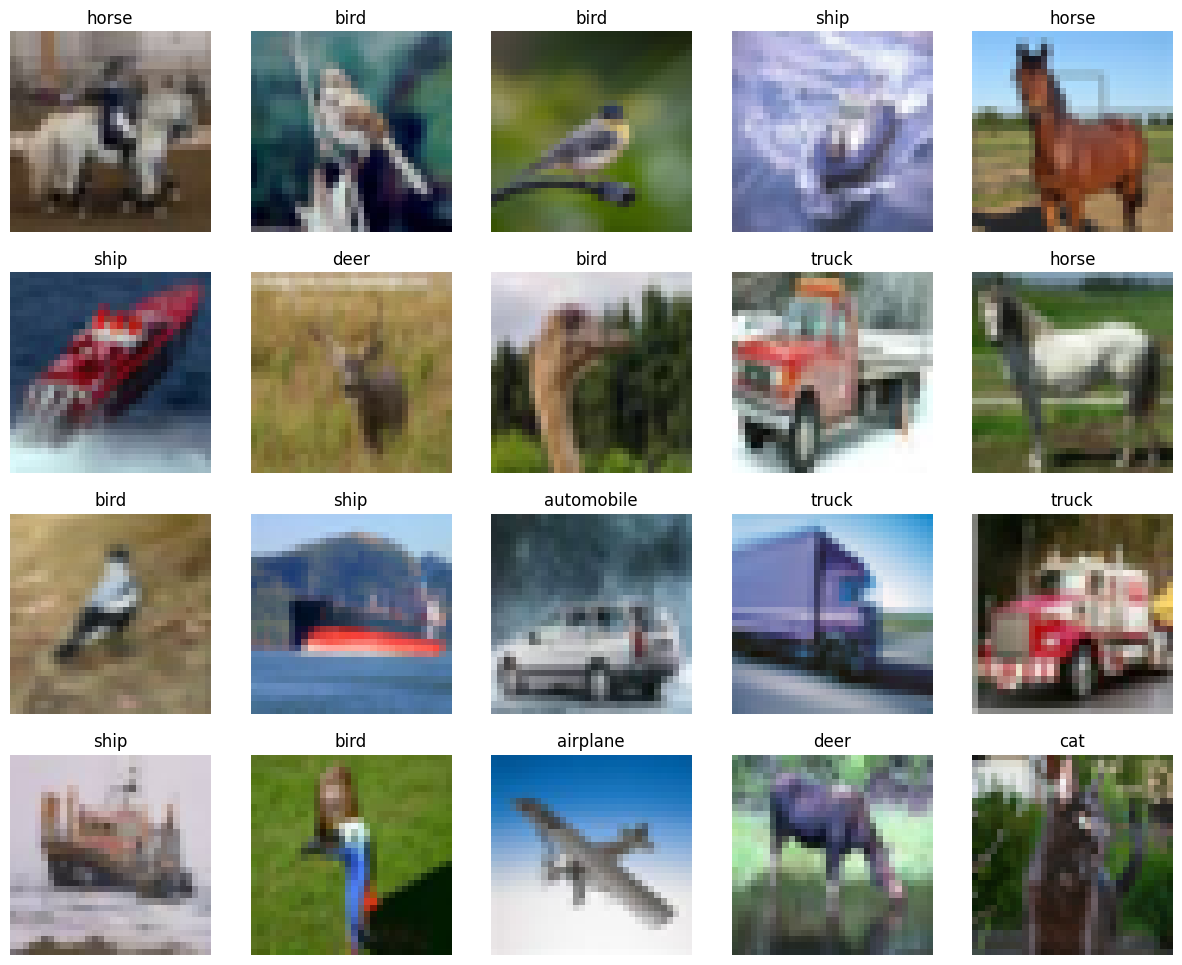

In [4]:
# Select random indices
random_indices = np.random.choice(len(X_train), size=20, replace=False)

# Plot the images
plt.figure(figsize=(15, 12))
for i, index in enumerate(random_indices):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[index])
    plt.title(class_names[y_train[index][0]])
    plt.axis('off')
plt.show()

## Data Augmentation

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,            # set input mean to 0 over the dataset
    samplewise_center=False,             # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,                 # apply ZCA whitening
    rotation_range=15,                   # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,                # randomly flip images
    vertical_flip=False                  # randomly flip images
)
datagen.fit(X_train)

# Normalization
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to categorical
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)


## Building CNN

In [6]:
# Model architecture
input_layer = Input(shape=(32, 32, 3))

# Convolutional layers
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=he_normal(), padding='same')(input_layer)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=he_normal(), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_normal(), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=he_normal(), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_initializer=he_normal(), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer=he_normal(), padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_initializer=he_normal())(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(10, activation='softmax')(x)

# Create model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0     

### Training

In [8]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    epochs=5,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


Epoch 1/5
782/782 [==============================] - 449s 573ms/step - loss: 1.4770 - accuracy: 0.4751 - val_loss: 1.5456 - val_accuracy: 0.5072
Epoch 2/5
782/782 [==============================] - 440s 563ms/step - loss: 1.1902 - accuracy: 0.5740 - val_loss: 1.1444 - val_accuracy: 0.6117
Epoch 3/5
782/782 [==============================] - 447s 572ms/step - loss: 1.0444 - accuracy: 0.6278 - val_loss: 1.1941 - val_accuracy: 0.6154
Epoch 4/5
782/782 [==============================] - 439s 561ms/step - loss: 0.9411 - accuracy: 0.6661 - val_loss: 0.8391 - val_accuracy: 0.7182
Epoch 5/5
782/782 [==============================] - 451s 577ms/step - loss: 0.8782 - accuracy: 0.6918 - val_loss: 0.8426 - val_accuracy: 0.7163


In [9]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=class_names))


313/313 [==============================] - 21s 66ms/step - loss: 0.8426 - accuracy: 0.7163
Validation loss: 0.8425973653793335
Validation accuracy: 0.7163000106811523
313/313 [==============================] - 23s 71ms/step
              precision    recall  f1-score   support

    airplane       0.72      0.81      0.76      1000
  automobile       0.81      0.93      0.87      1000
        bird       0.71      0.53      0.61      1000
         cat       0.65      0.39      0.49      1000
        deer       0.73      0.57      0.64      1000
         dog       0.79      0.51      0.62      1000
        frog       0.47      0.96      0.63      1000
       horse       0.79      0.81      0.80      1000
        ship       0.86      0.83      0.85      1000
       truck       0.86      0.82      0.84      1000

    accuracy                           0.72     10000
   macro avg       0.74      0.72      0.71     10000
weighted avg       0.74      0.72      0.71     10000



In [10]:
# Fully connected layers with L2 regularization
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_initializer=he_normal(), kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(10, activation='softmax', kernel_regularizer=l2(0.001))(x)
